# Resonator analysis using EPR method¶
1. Set-up and run a finite element simulate to extract the eigenmode.

2. Display EM fields to inspect quality of the setup.

3. Calculate EPR of substrate.

In [1]:
%load_ext autoreload
%autoreload 2

import qiskit_metal as metal
from qiskit_metal import designs, draw
from qiskit_metal import MetalGUI, Dict, Headings
import pyEPR as epr
### pyEPR !!

 # 1. Create the Resonator design

In [2]:
design = designs.DesignPlanar({}, True)
design.chips.main.size['size_x'] = '2mm'
design.chips.main.size['size_y'] = '2mm'

gui = MetalGUI(design)

In [3]:
from qiskit_metal.qlibrary.tlines.meandered import RouteMeander
from qiskit_metal.qlibrary.terminations.open_to_ground import OpenToGround
from qiskit_metal.qlibrary.terminations.short_to_ground import ShortToGround

design.delete_all_components()

otg = OpenToGround(design, 'open_to_ground', options=dict(pos_x='1.25mm',  pos_y='0um', orientation='0'))
stg = ShortToGround(design, 'short_to_ground', options=dict(pos_x='-1.25mm',  pos_y='0um', orientation='180'))
rt_meander = RouteMeander(design, 'readout',  Dict(
        total_length='6 mm',
        hfss_wire_bonds = True,
        fillet='90 um',
        lead = dict(start_straight='100um'),
        pin_inputs=Dict(
            start_pin=Dict(component='short_to_ground', pin='short'),
            end_pin=Dict(component='open_to_ground', pin='open')), ))

gui.rebuild()
gui.autoscale()

# 2. Analyze the resonator using the Eigenmode-EPR method

## Finite Element Eigenmode Analysis

In [4]:
from qiskit_metal.analyses.quantization import EPRanalysis
eig_res = EPRanalysis(design, "hfss")

In [5]:
hfss = eig_res.sim.renderer

In [6]:
hfss.start()

INFO 02:09PM [connect_project]: Connecting to Ansys Desktop API...
INFO 02:09PM [load_ansys_project]: 	Opened Ansys App
INFO 02:09PM [load_ansys_project]: 	Opened Ansys Desktop v2021.1.0
INFO 02:09PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Users/Airplane/OneDrive - skku.edu/문서/Ansoft/
	Project:   Project1
INFO 02:09PM [connect_design]: No active design found (or error getting active design).
INFO 02:09PM [connect]: 	 Connected to project "Project1". No design detected


True

In [7]:
hfss.activate_ansys_design("Readout", 'eigenmode')

02:09PM 51s WARNING [activate_ansys_design]: The design_name=Readout was not in active project.  Designs in active project are: 
[].  A new design will be added to the project.  
INFO 02:10PM [connect_design]: 	Opened active design
	Design:    Readout [Solution type: Eigenmode]
WARNING 02:10PM [connect_setup]: 	No design setup detected.
WARNING 02:10PM [connect_setup]: 	Creating eigenmode default setup.
INFO 02:10PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


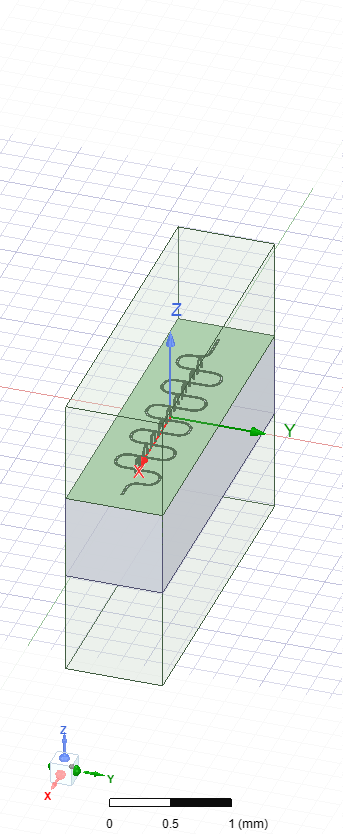

WindowsPath('C:/Users/Airplane/JupyterProject/ansys.png')

In [8]:
hfss.render_design(['short_to_ground', 'readout', 'open_to_ground'], [])
hfss.save_screenshot()

In [9]:
# Analysis properties
setup = hfss.pinfo.setup
setup.passes = 20
print(f"""
Number of eigenmodes to find             = {setup.n_modes}
Number of simulation passes              = {setup.passes}
Convergence freq max delta percent diff  = {setup.delta_f}
""")

# Next 2 lines are counterinuitive, since there is no junction in this resonator.
# However, these are necessary to make pyEPR work correctly. Please do note delete
hfss.pinfo.design.set_variable('Lj', '10 nH')
hfss.pinfo.design.set_variable('Cj', '0 fF')


Number of eigenmodes to find             = 1
Number of simulation passes              = 20
Convergence freq max delta percent diff  = 0.1



'Cj'

### Due to License Issue diconnect metal from ansys

In [10]:
hfss.close()

True

## after ansys complete -> get the results

In [11]:
hfss.start()

INFO 02:15PM [connect_project]: Connecting to Ansys Desktop API...
INFO 02:15PM [load_ansys_project]: 	Opened Ansys App
INFO 02:15PM [load_ansys_project]: 	Opened Ansys Desktop v2021.1.0
INFO 02:15PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Users/Airplane/OneDrive - skku.edu/문서/Ansoft/
	Project:   Tutorial_Eigenmode&EPR
INFO 02:15PM [connect_design]: 	Opened active design
	Design:    Readout [Solution type: Eigenmode]
INFO 02:15PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 02:15PM [connect]: 	Connected to project "Tutorial_Eigenmode&EPR" and design "Readout" 😀 



True

In [12]:
eig_res.sim.convergence_t, eig_res.sim.convergence_f, _ = hfss.get_convergences()
eig_res.sim.plot_convergences()

02:15PM 57s INFO [get_f_convergence]: Saved convergences to C:\Users\Airplane\JupyterProject\hfss_eig_f_convergence.csv


02:16PM 06s WARNING [plot_ansys_fields]: This method is deprecated. Change your scripts to use plot_fields()


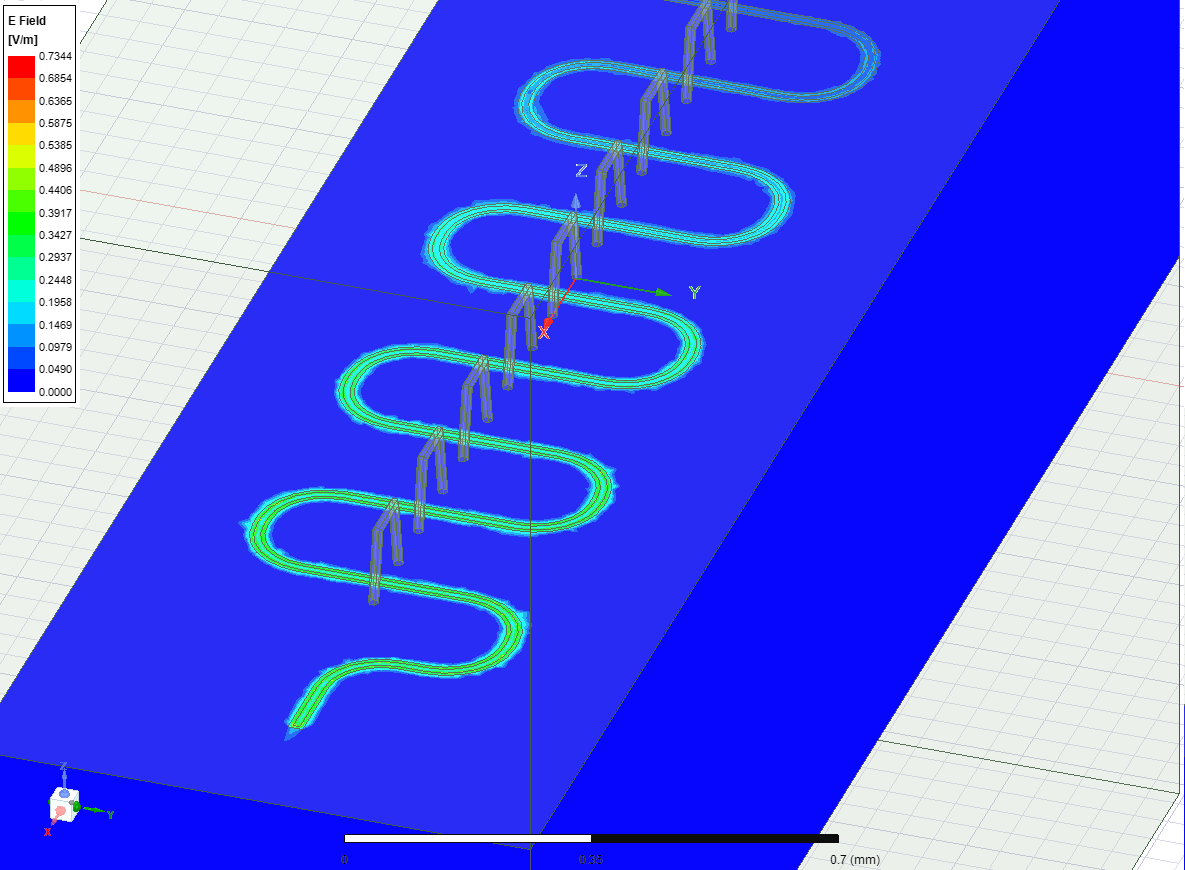

WindowsPath('C:/Users/Airplane/JupyterProject/ansys.png')

In [13]:
hfss.modeler._modeler.ShowWindow()
hfss.plot_ansys_fields('main')
hfss.save_screenshot()

In [14]:
hfss.plot_ansys_delete(['Mag_E1'])

02:16PM 42s WARNING [plot_ansys_delete]: This method is deprecated. Change your scripts to use clear_fields()


# EPR Analysis

In [15]:
eig_res.epr_start(no_junctions=True)

Design "Readout" info:
	# eigenmodes    1
	# variations    1


{'junctions': {}, 'dissipatives': {'dielectrics_bulk': ['main']}}

In [16]:
eprd = hfss.epr_distributed_analysis

In [17]:
ℰ_elec = eprd.calc_energy_electric()
ℰ_elec_substrate = eprd.calc_energy_electric(None, 'main')
ℰ_mag = eprd.calc_energy_magnetic()

print(f"""
ℰ_elec_all       = {ℰ_elec}
ℰ_elec_substrate = {ℰ_elec_substrate}
EPR of substrate = {ℰ_elec_substrate / ℰ_elec * 100 :.1f}%

ℰ_mag    = {ℰ_mag}
""")


ℰ_elec_all       = 2.8705840727643e-24
ℰ_elec_substrate = 2.62823545348087e-24
EPR of substrate = 91.6%

ℰ_mag    = 2.87065172379543e-24



In [18]:
eig_res.sim.close()